In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.io import loadmat
from scipy.stats import rv_discrete
from scipy import sparse
import glob
import re

In [97]:
with open('init_state.txt', 'r') as file:
    init_state = file.read()
init_state = json.loads(init_state)

with open('mdp_dict_chosen.txt', 'r') as file:
    mdp_dict = file.read()
mdp_dict = json.loads(mdp_dict)

def get_mat(mdp_name, paths):

    feat_to_incl = mdp_dict[mdp_name]
    matrix = loadmat('{}/{}.mat'.format(paths['matlab'], mdp_name))
    policy = pd.read_csv('{}/policy_{}.csv'.format(paths['policy_csv'], mdp_name))
    PI_policy = policy['policy'].values
    state_idx = matrix['state_idx'][0]

    state_0 = ''
    for feat in feat_to_incl:
        state_0 += init_state[feat]

    state_0_idx = np.where(state_idx == int(state_0))[0].item()
    return matrix, state_0_idx, PI_policy

def simulator(matrix, policy, sim_length, state_0_idx):

    state = state_0_idx
    cumul_reward = 0
    cumreward_per_step = [0]
    discount_factor = 0.99

    for n in range(sim_length):
        action = policy[state]
        if not isinstance(action, np.int64):
            # policy provided is stochastic
            custm_act = rv_discrete(name='custm_act', values=(np.arange(len(action)), action))
            action = custm_act.rvs(size = 1)[0]
        pk = matrix['P'][0, action][state,:].toarray().flatten()
        custm = rv_discrete(name='custm', values=(np.arange(len(pk)), pk))
        n_state = custm.rvs(size = 1)[0]
        reward = matrix['R'][0,action][state,n_state]
        cumul_reward += reward*discount_factor**n
        state = n_state
        cumreward_per_step = np.append(cumreward_per_step, cumul_reward)
        
    return cumreward_per_step

### Constructing Behaviour Policy

In [67]:
transitions = pd.read_csv('trans_ori/original_transitions_MDP_aug4687.csv')
transitions['state'] = transitions['state'] .astype('str')
transitions['next_state'] = transitions['next_state'] .astype('str')

sa_count = transitions.groupby(['state','action']).sum()['support']
s_count = transitions.groupby(['state']).sum()['support']
behaviour_policy = sa_count/s_count
behaviour_policy.rename('behaviour_policy', inplace = True)
behaviour_policy = behaviour_policy.reset_index().pivot(index ='state', columns = 'action')
behaviour_policy.fillna(0, inplace = True)

### Compile relevant MDPs & Run Simulation


Compiling:

MDP_lp
MDP_aug4
MDP_aug46
MDP_aug468
MDP_aug4687

Running simulations:

MDP_lp
MDP_aug4
MDP_aug46
MDP_aug468
MDP_aug4687
Behaviour Policy

Plotting results:



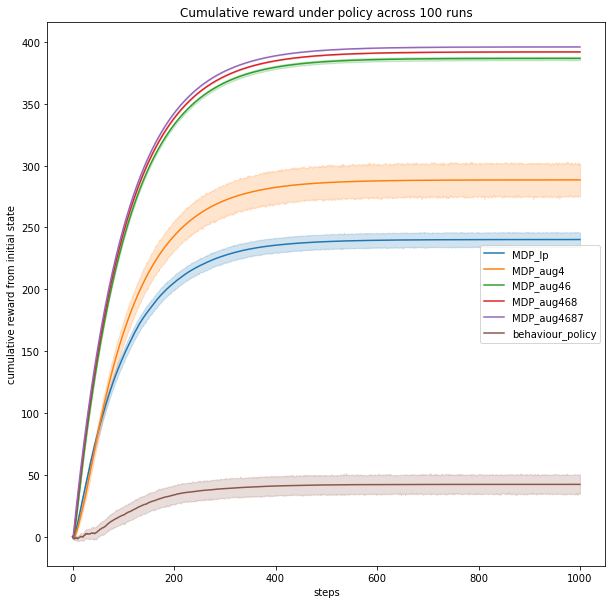

In [106]:
paths = {'matlab': 'matlab_files', 'policy_csv': 'policies'}
matrices = []
state_0_indices = []
policies = []
sim_length = 1000
n_sims = 100

print('\nCompiling:\n')
for mdp_name in mdp_dict.keys():
    print(mdp_name)
    matrix, state_0_idx, policy = get_mat(mdp_name, paths)
    matrices.append(matrix)
    state_0_indices.append(state_0_idx)
    policies.append(policy)
    
print('\nRunning simulations:\n')
results = {}
for matrix, state_0_idx, policy, mdp_name in zip(matrices, state_0_indices, policies, mdp_dict):
    print(mdp_name)
    np.random.seed(100)
    rewards_record = []
    for i in range(n_sims):
        rewards = simulator(matrix, policy, sim_length, state_0_idx)
        rewards_record.append(rewards)
        
    results[mdp_name] = rewards_record

# Behaviour Policy
print('Behaviour Policy')
mdp_name = "MDP_aug4687"
matrix, state_0_idx,_ = get_mat(mdp_name, paths)
rewards_record = []
for i in range(n_sims):
    rewards = simulator(matrix, behaviour_policy.values, sim_length, state_0_idx)
    rewards_record.append(rewards)
results['behaviour_policy'] = rewards_record
    
print('\nPlotting results:\n')
fig, ax = plt.subplots(figsize=(10,10))
for mdp_name, result in results.items():
    y = np.array(results[mdp_name]).flatten()
    x = list(range(sim_length + 1))*n_sims
    sns.lineplot(x = x, y = y, ax = ax, label = mdp_name)
    
ax.set_xlabel('steps')
ax.set_ylabel('cumulative reward from initial state')
ax.set_title('Cumulative reward under policy across {} runs'.format(n_sims))
plt.savefig('Saved_Figs/MC_policy_evaluation_of_different_representations.pdf')
plt.show()

### Repeating for penalised MDPs


Compiling:

MDP_lp
MDP_aug4
MDP_aug46
MDP_aug468
MDP_aug4687

Running simulations:

MDP_lp
MDP_aug4
MDP_aug46
MDP_aug468
MDP_aug4687
Behaviour Policy

Plotting results:



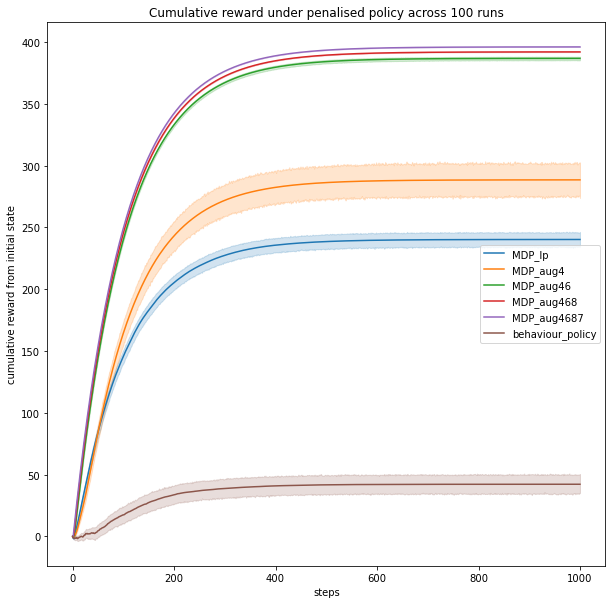

In [107]:
paths = {'matlab': 'matlab_files_penalised', 'policy_csv': 'policies_penalised'}
matrices = []
state_0_indices = []
policies = []
sim_length = 1000
n_sims = 100

print('\nCompiling:\n')
for mdp_name in mdp_dict.keys():
    print(mdp_name)
    matrix, state_0_idx, policy = get_mat(mdp_name, paths)
    matrices.append(matrix)
    state_0_indices.append(state_0_idx)
    policies.append(policy)

print('\nRunning simulations:\n')
results = {}
for matrix, state_0_idx, policy, mdp_name in zip(matrices, state_0_indices, policies, mdp_dict):
    print(mdp_name)
    np.random.seed(100)
    rewards_record = []
    for i in range(n_sims):
        rewards = simulator(matrix, policy, sim_length, state_0_idx)
        rewards_record.append(rewards)
        
    results[mdp_name] = rewards_record

# Behaviour Policy
print('Behaviour Policy')
mdp_name = "MDP_aug4687"
matrix, state_0_idx,_ = get_mat(mdp_name, paths)
rewards_record = []
for i in range(n_sims):
    rewards = simulator(matrix, behaviour_policy.values, sim_length, state_0_idx)
    rewards_record.append(rewards)
results['behaviour_policy'] = rewards_record

print('\nPlotting results:\n')
fig, ax = plt.subplots(figsize=(10,10))
for mdp_name, result in results.items():
    y = np.array(results[mdp_name]).flatten()
    x = list(range(sim_length + 1))*n_sims
    sns.lineplot(x = x, y = y, ax = ax, label = mdp_name)
    
ax.set_xlabel('steps')
ax.set_ylabel('cumulative reward from initial state')
ax.set_title('Cumulative reward under penalised policy across {} runs'.format(n_sims))
plt.savefig('Saved_Figs/MC_policy_evaluation_of_penalised_representations.pdf')
plt.show()

### Testing CQL policies (will fail due to OOD actions)

In [10]:
paths = {'matlab': 'Dynamic Programming/matlab_files_penalised', 'policy_csv': 'policies_cql'}

print('\nCompiling:\n')
mdp_name = list(mdp_dict.keys())[-1]
matrix, state_0_idx, _ = get_mat(mdp_name, paths)
policy_csv = glob.glob('policies_CQL/policy*')

policies = []
for csv in policy_csv:
    policies.append(pd.read_csv(csv)['policy'])

print('\nRunning simulations:\n')
results = {}
for policy, csv in zip(policies, policy_csv):
    mdp_name = re.sub(r'policies_CQL\\policy_',"", csv)
    mdp_name = re.sub(r'.csv', '', mdp_name)
    print(mdp_name)
    np.random.seed(100)
    sim_length = 1000
    n_sims = 100
    rewards_record = []
    for i in range(n_sims):
        rewards = simulator(matrix, policy, sim_length, state_0_idx)
        rewards_record.append(rewards)
        
    results[mdp_name] = rewards_record

print('\nPlotting results:\n')
fig, ax = plt.subplots(figsize=(10,10))
for mdp_name, result in results.items():
    y = np.array(results[mdp_name]).flatten()
    x = list(range(sim_length + 1))*100
    sns.lineplot(x = x, y = y, ax = ax, label = mdp_name)
    
ax.set_xlabel('steps')
ax.set_ylabel('cumulative reward from initial state')
ax.set_title('Cumulative reward under CQL policies across {} runs'.format(n_sims))
plt.savefig('Saved_Figs/MC_policy_evaluation_of_CQL_policies.pdf')
plt.show()


Compiling:


Running simulations:

lim_q_iqn
lim_q_mean
lim_q_qr


KeyboardInterrupt: 